# Dynamic Time Warping

## Files and Data
#### ground-truth folder
Contains ground truth data.


#### transcription.txt  
- XXX-YY-ZZ: XXX = Document Number, YY = Line Number, ZZ = Word Number
- Contains the character-wise transcription of the word (letters seperated with dashes)
- Special characters denoted with s_
	- numbers (s_x)
	- punctuation (s_pt, s_cm, ...)
	- strong s (s_s)
	- hyphen (s_mi)
	- semicolon (s_sq)
	- apostrophe (s_qt)
	- colon (s_qo)
    
### Task
Three files:  
##### training and test data:
train.txt, valid.txt
both contain a list of documents
##### keywords that are at least once in the training and validation set defined by train.txt and valid.txt
keywords.txt



In [1]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
import cv2
import os

In [2]:
IMAGES_PATH = "./word-images/"
DIRS = sorted([name for name in os.listdir(IMAGES_PATH)])

#Testing
print(DIRS)

['270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '300', '301', '302', '303', '304']


In [3]:
# returns list of numpy arrays with the pixel values
def import_images():
    images = list()
    id_ = 0
    for folder in DIRS:
        img_paths = IMAGES_PATH + folder
        # this sorts png files in the numerical order rather then the fancy string order
        # pls do not touch
        sorted_image_file_paths = [str(p) + ".png" for p in sorted([int(i.strip(".png")) for i in os.listdir(img_paths)])]
        for image in sorted_image_file_paths:
            images.append({ "id": id_, "document": folder, "image": cv2.imread(img_paths + "/" + image,0) })
            id_ += 1
    return images

def display_image(image):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [8]:
# image size reduction

# changes grey image to binary image
def binarize(image, treshold=250):
    for index in range(len(image)):
        image[index] =  0 if image[index] < treshold else 1
    return image

# removes leading and trailing white pixels from binary image
def trim_lead_and_tail(image):
    start = -1
    end = len(image)
    index = 0
    for value in image:
        # first black value
        if start == -1 and value < 1:
            start = index -1
        # last black value
        if value < 1:
            end = index
        index += 1
    return image[start:end]

def reduce_image(image):
    # flatten array
    image = np.array(np.hstack(image))
    image = binarize(image)
    image = trim_lead_and_tail(image)
    return image

# Testing
# can only be run after image import
image = IMAGES[0]['image']
print(image)
print(image.shape)
image = reduce_image(image)
print(image)
print(image.shape)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
(200, 200)
[1 0 0 ... 0 0 0]
(24375,)


In [5]:
# get the transcription of all words
def get_file(filepath):
    lines = list()
    with open(filepath, 'r') as f:
        lines = f.read().splitlines()
    return lines

# unpacks a row from the transcript, return a dict with the corresponding values
def parse_transcript_row(row):
    metadata, word = row.split(" ")
    document, line, col = metadata.split("-")
    # special_char = ""
    # if "_" in word:
    #   word, special_chars = word.split("_")
    return {"document": document, "line": line, "col": col, "word": word}

# Testing
parse_transcript_row("274-20-02 C-a-t-t-l-e-s_cm")

# parse all words to usable dict
def parse_transcript(transcript):
    data = dict()
    id_counter = 0
    for row in transcript:
        data[id_counter] = parse_transcript_row(row)
        id_counter += 1
    return data

# finds an entry in the transcript based on the word, returns all found entries ids
def find_by_word(transcript, word):
    ids = list()
    for id_, item in transcript.items():
        if item['word'] == word:
            ids.append(id_)
    return ids

# Testing
transcript = np.array(["275-07-09 r-e-m-a-r-k-a-b-l-y",
                      "275-08-01 a-w-k-w-a-r-d-s_cm", "275-08-02 p-a-r-t-i-c-u-l-a-r"])
transcript = parse_transcript(transcript)
print(transcript)

print(find_by_word(transcript, "a-w-k-w-a-r-d-s_cm"))

{0: {'document': '275', 'line': '07', 'col': '09', 'word': 'r-e-m-a-r-k-a-b-l-y'}, 1: {'document': '275', 'line': '08', 'col': '01', 'word': 'a-w-k-w-a-r-d-s_cm'}, 2: {'document': '275', 'line': '08', 'col': '02', 'word': 'p-a-r-t-i-c-u-l-a-r'}}
[1]


{'document': '273', 'line': '23', 'col': '05', 'word': 'A-l-e-x-a-n-d-r-i-a'}


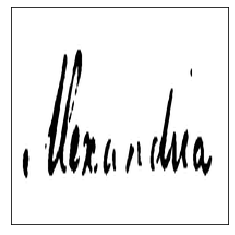

In [6]:
# files where keywords for validation are located
VALID_DOCUMENT_IDS = get_file('valid.txt')
# files where keywords for training are located
TRAIN_DOCUMENT_IDS = get_file('train.txt')
# list of words which are present in the training set and also in the valid set
KEYWORDS = get_file('keywords.txt')
# dict of images with pages and image as np array
IMAGES = import_images()

transcript_list = get_file('ground-truth/transcription.txt')
# final transcript with all infos about words
TRANSCRIPT = parse_transcript(transcript_list)

## the id for IMAGES corresponds to the word in TRANSCRIPT. so IMAGES[1] is the word in TRANSCRIPT[1]

print(TRANSCRIPT[872])
display_image(IMAGES[872]['image'])


In [11]:
## Reduce images to flat, binary, trimmed array
IMAGES_REDUCED = IMAGES
for image in IMAGES_REDUCED:
    image['image'] = reduce_image(image['image']) 

initial size 30128
reduced size 30128


In [15]:
# save dictionary with images and load it again
import pickle

def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
save_obj(IMAGES_REDUCED, "images_reduced")

## Testing

In [ ]:
# example usage for find_by_word
ids_ = find_by_word(TRANSCRIPT, 'A-l-e-x-a-n-d-r-i-a')
print(ids_)

print([TRANSCRIPT[ids_[0]]])
display_image(IMAGES[ids_[0]]['image'])



In [17]:
testing = load_obj("images_reduced")
print(getsizeof(testing))

33648


In [ ]:
# image size reduction

# changes grey image to binary image
def binarize(image, treshold=250):
    for index in range(len(image)):
        image[index] =  0 if image[index] < treshold else 1
    return image

# removes leading and trailing white pixels from binary image
def trim_lead_and_tail(image):
    start = -1
    end = len(image)
    index = 0
    for value in image:
        # first black value
        if start == -1 and value < 1:
            start = index -1
        # last black value
        if value < 1:
            end = index
        index += 1
    return image[start:end]

def reduce_image(image):
    # flatten array
    image = np.array(np.hstack(image))
    image = binarize(image)
    image = trim_lead_and_tail(image)
    return image

# Testing
image = IMAGES[0]['image']
print(image)
print(image.shape)
image = reduce_image(image)
print(image)
print(image.shape)

In [ ]:
image1 = np.array(np.hstack(IMAGES[0]['image']))
print(len(image1))
print(image1)

display_image(IMAGES[0]['image'])

#index = np.argmax(image1 < 255)
count = 0
for value in image1:
    # if value < 255:
        # print("wow found a value" + str(value) + " at " + str(count))
    count += 1

print(len(image1))

In [ ]:
# trims the leading and trailing white pixels

In [ ]:
# distance calculation test for 20 images compared to image 0
image1 = np.concatenate(IMAGES[0]['image'])
images = [np.concatenate(image['image']) for image in IMAGES[19:20]]
print(image1)

import time
from dtaidistance import dtw
import dtaidistance
image1 = np.array(image1, dtype=np.double)
start = time.time()
for image in images:
    break
    print(image)
    distance = dtw.distance_fast(image1, np.array(image, dtype=np.double), max_dist=4000,)
    print(distance)
end = time.time()
print("took: " + str(round(end - start, 2)) + " seconds")
    

In [ ]:
### Testing of dtaidistance https://dtaidistance.readthedocs.io/en/latest/usage/installation.html

from dtaidistance import dtw
import time

result = dtw.try_import_c()
print(result)

image1 = np.array(np.concatenate(IMAGES[0]['image']), dtype=np.float)
image2 = np.array(np.concatenate(IMAGES[19]['image']), dtype=np.float)
display_image(IMAGES[1]['image'])
display_image(IMAGES[19]['image'])

start = time.time()
distance = dtw.distance_fast(image1, image2)
end = time.time()
print(distance)
print("took: " + str(end - start))

In [ ]:
### Testing of dtw https://github.com/pierre-rouanet/dtw

import numpy as np

# We define two sequences x, y as numpy array
# where y is actually a sub-sequence from x
x = np.array([2, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
y = np.array([1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)

from dtw import dtw


manhattan_distance = lambda x, y: np.abs(x - y)

result = dtw(x, y)

print(result)

# You can also visualise the accumulated cost and the shortest path



In [ ]:
### Testing of dtw-python library https://dynamictimewarping.github.io/py-api/html/

import dtw
import numpy as np

print(np.concatenate(IMAGES[0]['image']))
query = np.concatenate(IMAGES[0]['image'])

## A cosine is for template; sin and cos are offset by 25 samples
template = np.concatenate(IMAGES[1]['image'])

## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(query, template, window_type="sakoechiba")

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
#dtw(query, template, 
#    step_pattern=rabinerJuangStepPattern(6, "c"))\
#    .plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
#print(rabinerJuangStepPattern(6,"c"))
#rabinerJuangStepPattern(6,"c").plot()

## And much more!


In [ ]:
images = [np.array(np.concatenate(image['image']), dtype=np.double) for image in IMAGES[:20]]
series = [
    np.array([0, 0, 1, 2, 1, 0, 1, 0, 0], dtype=np.double),
    np.array([0.0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0]),
    np.array([0.0, 0, 1, 2, 1, 0, 0, 0])
]
ds = dtw.distance_matrix_fast(series)

### **dtaidistance:** fancy pantsy library for DTW
##### Installation:
`pip install dtaidistance`  
**github:** [github-repo for dtaidistance](https://github.com/wannesm/dtaidistance)

In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
x = np.arange(0, 20, .5)
s1 = np.sin(x)
s2 = np.sin(x - 1)
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)


In [ ]:
print(len(IMAGES))

In [ ]:
image1 = np.array(np.concatenate(IMAGES[0]['image']), dtype=np.float)
image2 = np.array(np.concatenate(IMAGES[19]['image']), dtype=np.float)
#print(IMAGES[872])
#print(IMAGES[2007])

display_image(IMAGES[1]['image'])
display_image(IMAGES[19]['image'])
distance = dtw.distance_fast(image1, image2)
print(distance)

image1 = np.array(np.concatenate(IMAGES[872]['image']), dtype=np.float)
image2 = np.array(np.concatenate(IMAGES[2007]['image']), dtype=np.float)
#print(IMAGES[872])
#print(IMAGES[2007])

display_image(IMAGES[872]['image'])
display_image(IMAGES[2007]['image'])
distance = dtw.distance_fast(image1, image2)
print(distance)


In [ ]:
from dtaidistance import dtw

result = dtw.try_import_c()
print(result)

### DTW required steps
- [ ] initialize matrix
- [ ] calculate each field in the matrix
- [ ] find the shortest path from 0,0 to i,j through the matrix by iterating and increasing either i, j or both
##### Efficiency
- [ ] only calculate matrix fields within a certain treshold (Sakoe-Chiba Band)

In [ ]:
### Custom DTW
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [ ]:
from PIL import Image
images = import_images()
print(len(images[0]))

# result = dtw([1,2,3], [2,2,2,2,3,4])
# print("result: " + str(result))
display_image(images[0])


#### Steps for the task
- get all images
- convert each image to a numpy array with dtype np.double

In [ ]:
from PIL import Image
import numpy as np

images = import_images()

print(np.asarray(images[0]))

display_image(images[0])